# Datasets preparation

In [10]:
import polars as pl

defs = pl.read_csv("../data/definitions_corpus/definitions.csv")

definendums_list = (defs.select(
    pl.col('label')
    .str.replace('#', '')
    .str.replace(r'([a-zà-ÿ])([A-Z])', r'${1} ${2}', n=-1)
    .str.to_lowercase()
)
)['label'].to_list()

print(definendums_list)

['obstacles to trade', 'injury', 'adverse trade effects', 'union industry', 'union enterprise', 'services', 'ancillary services undertaking', 'authorisation', 'branch', 'close links', 'competent authority', 'commodity and emission allowance dealer', 'control', 'compliance with the group capital test', 'credit institution', 'derivatives', 'financial institution', 'gender neutral remuneration policy', 'group', 'consolidated situation', 'group supervisor', 'home member state', 'host member state', 'initial capital', 'investment firm', 'investment firm group', 'investment holding company', 'investment services and activities', 'management body', 'management body in its supervisory function', 'mixed financial holding company', 'means aparent undertaking other than afinancial holding company', 'senior management', 'parent undertaking', 'subsidiary', 'systemic risk', 'union parent investment firm', 'union parent investment holding company', 'union parent mixed financial holding company', 'inv

### Qualitative

In [3]:
leos_eval_dataset = pl.read_excel("./datasets/qualitative/Evaluation_LEOS_annotato_def.xlsx")

In [4]:
leos_dict = leos_eval_dataset.select(["CELEX", "Definition"]).rename({"CELEX": "CELEX_ID", "Definition": "Term"}).to_dicts()

In [5]:
from rapidfuzz import process, fuzz

leos_retrieval = []
leos_generation = []

for el in leos_dict:
    x = process.extract(el['Term'].lower(), definendums_list, scorer=fuzz.token_sort_ratio, limit=1, score_cutoff=95)
    if x: 
        leos_retrieval.append(el)
    else:
        leos_generation.append(el)

In [6]:
print(len(leos_retrieval), len(leos_generation))

5 85


### LexDrafter

In [7]:
import polars as pl
from rapidfuzz import process, fuzz


lexdrafter_df = pl.read_json('./datasets/lexdrafter/corpus.json')['celex_id', 'term', 'term_definition']

lexdrafter_df.head()

celex_id,term,term_definition
str,str,str
"""32019R2014""","""mains""","""'mains' means the electricity …"
"""32019R2014""","""electric mains""","""'electric mains' means the ele…"
"""32019R2014""","""automatic washing machine""","""'automatic washing machine' me…"
"""32019R2014""","""household washing machine""","""'household washing machine' me…"
"""32019R2014""","""household washer-dryer""","""'household washer-dryer' means…"


In [8]:
lexdrafter_retrieval = []
lexdrafter_generation = []

for entry in lexdrafter_df.rename({'celex_id': 'CELEX_ID', 'term': 'Term', 'term_definition': 'original_definition'}).to_dicts():
    x = process.extract(entry['Term'].lower(), definendums_list, scorer=fuzz.token_sort_ratio, limit=1, score_cutoff=95)
    if x: 
        lexdrafter_retrieval.append(entry)
    else:
        lexdrafter_generation.append(entry)

In [9]:
print(len(lexdrafter_retrieval), len(lexdrafter_generation))

696 634


### Multi-Legislation

In [88]:
import polars as pl

cols = ['id',
 'definition_text',
 'def_n',
 'document_id',
 'frbr_work',
 'frbr_expression']

juris_df = defs.group_by(['label', 'dataset']).agg(pl.all()).sort('label').filter(pl.col('label').is_duplicated()).explode(cols)#.group_by('label').agg(pl.all()).sort('label')

juris_df

label,dataset,id,definition_text,def_n,document_id,frbr_work,frbr_expression
str,str,i64,str,str,str,str,str
"""#GISIS""","""Normattiva""",12382,"""GISIS: sistema globale integra…","""#def_15""","""20211130_21G00201_VIGENZA_2024…","""/akn/it/act/decretoLegislativo…","""/akn/it/act/decretoLegislativo…"
"""#GISIS""","""EurLex""",9063,"""GISIS: means the Global Integr…","""#def_14""","""32019L0883.xml""","""/akn/eu/act/directive/2019-04-…","""/akn/eu/act/directive/2019-04-…"
"""#ISEE""","""Normattiva""",13012,"""ISEE: l'indicatore della situa…","""#def_5""","""20171013_17G00161_VIGENZA_2023…","""/akn/it/act/decretoLegislativo…","""/akn/it/act/decretoLegislativo…"
"""#ISEE""","""Normattiva""",15534,"""ISEE: indicatore della situazi…","""#def_1""","""20140124_14G00009_VIGENZA_2021…","""/akn/it/act/decretoDelPresiden…","""/akn/it/act/decretoDelPresiden…"
"""#ISEE""","""PDL""",16198,"""ISEE: l'indicatore della situa…","""#def_1""","""18PDL0019020_PD.xml""","""/akn/it/bill/propostaDiLegge/2…","""/akn/it/bill/propostaDiLegge/2…"
…,…,…,…,…,…,…,…
"""#utente""","""Normattiva""",13710,"""utente: l'armaiolo, il suo rap…","""#def_27""","""20230817_23G00124_ORIGINALE.xm…","""/akn/it/act/decreto/ministeroI…","""/akn/it/act/decreto/ministeroI…"
"""#utente""","""Normattiva""",14230,"""utente: il soggetto che accede…","""#def_4""","""20230531_23G00065_ORIGINALE.xm…","""/akn/it/act/decreto/ministeroA…","""/akn/it/act/decreto/ministeroA…"
"""#utente""","""Normattiva""",14263,"""utente: persona fisica, che ag…","""#def_5""","""20211026_21G00159_ORIGINALE.xm…","""/akn/it/act/decreto/presidenza…","""/akn/it/act/decreto/presidenza…"


In [54]:
from LegalDefAgent.src.utils import camelcase_to_spaces
from pprint import pprint
import json

z = []

for el in juris_df.filter(pl.col('dataset').list.contains('EurLex')).to_dicts():
    term = camelcase_to_spaces(el['label'])
    num_jurisdictions = len(el['dataset'])
    for i in range(num_jurisdictions):
        entry = {
            "label": el['label'],
            "term": term,
            "dataset": el['dataset'][i],
            "id": el['id'][i][0] if el['id'][i] else None,
            "definition_text": el['definition_text'][i][0] if el['definition_text'][i] else None,
            "def_n": el['def_n'][i][0] if el['def_n'][i] else None,
            "document_id": el['document_id'][i][0].split('.')[0] if el['document_id'][i] else None,
        }
        z.append(entry)
    
pprint(z)


with open('./datasets/legislation_definitions.json', 'w') as f:
    json.dump(z, f, indent=4)

[{'dataset': 'EurLex',
  'def_n': '#def_14',
  'definition_text': 'GISIS: means the Global Integrated Shipping Information '
                     'System set up by the IMO;',
  'document_id': '32019L0883',
  'id': 9063,
  'label': '#GISIS',
  'term': 'gisis'},
 {'dataset': 'Normattiva',
  'def_n': '#def_15',
  'definition_text': 'GISIS: sistema globale integrato di informazione sul '
                     "traffico marittimo istituito dall'Organizzazione "
                     'marittima internazionale (IMO);',
  'document_id': '20211130_21G00201_VIGENZA_20240423',
  'id': 12382,
  'label': '#GISIS',
  'term': 'gisis'},
 {'dataset': 'Normattiva',
  'def_n': '#def_6',
  'definition_text': "ISIN: l'Ispettorato nazionale per la sicurezza nucleare "
                     "e la radioprotezione, di cui all'articolo 6 del decreto "
                     'legislativo 4 marzo 2014, n. 45.',
  'document_id': '20160809_16G00165_ORIGINALE',
  'id': 11539,
  'label': '#ISIN',
  'term': 'isin'},
 {'dat

---

# Run the evaluation

#### Retrieval - Generation

In [7]:
from LegalDefAgent.src.agents import definitions_agent_eval
import uuid

async def get_definition(definendum, model):
    inputs = {"messages": [("user", f"what's the definition of {definendum}?")]}
    configurable = {"configurable": {"user_id": "1", "thread_id": uuid.uuid4().hex, "model": model}}

    async for msg in definitions_agent_eval.astream(inputs, configurable, stream_mode="values"):
        chat = msg

    return chat

2025-02-14 21:17:54,134 - INFO - Logging configured


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

2025-02-14 21:17:57,775 - INFO - loading existing colbert_linear and sparse_linear---------


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

2025-02-14 21:17:59,317 - INFO - loading existing colbert_linear and sparse_linear---------


In [ ]:
import json
import logging
from pathlib import Path
import time
import ast


DATASET_MAP = {
    'leos': {
        'generation': leos_generation,
        'retrieval': leos_retrieval
    },
    'lexdrafter': {
        'generation': lexdrafter_generation,
        'retrieval': lexdrafter_retrieval
    }
}

model = 'together-llama-3.3-70B-Instruct-Turbo'
dataset_name = 'lexdrafter'
task = 'generation'


Path('logs').mkdir(exist_ok=True)

logging.basicConfig(
    filename=f'logs/evaluation_log_{model}_{dataset_name}_{task}_.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)

last = 0

output_file = f'{model}_{dataset_name}_{task}_.json'

if Path(output_file).exists():
    with open(output_file, 'r') as f:
        results = ast.literal_eval(f.read())
        last = results[-1]['#']
    logging.info(f"Loaded {len(results)} existing results")
else:
    results = []
    logging.info("Starting new results file")

dataset = DATASET_MAP[dataset_name][task]

for i, item in enumerate(dataset[last:], last+1):
    item.update({"#": i})
    try:
        logging.info(f"Processing item {i}/{len(dataset)}: {item['Term']}")
        res = await get_definition(item['Term'], model)
        response_json = json.loads(res['messages'][-1].content)
        item['response'] = response_json
        results.append(item)

        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        logging.info(item)
        print(f'{i}/{len(dataset)}', item)
        time.sleep(2)
    
    except Exception as e:
        logging.error(f"Error processing item {item['CELEX_ID']} ({item['Term']}): {str(e)}")
        item['response'] = {"error": str(e)}
        print(f'{i}/{len(dataset)} Error', item)
        results.append(item)

    #logging.error(f"Error processing item {item['CELEX_ID']} ({item['Term']}): {str(e)}")
    #item['response'] = {"error": str(e)}
    #print('Error', item)
    #results.append(item)

logging.info(f"Processing complete. Processed {len(results)} items.")

1/38 {'CELEX_ID': '32019R2013', 'Term': 'HiNA', 'term_definition': "'HiNA' means High Network Availability as defined in Article 1 of Commission Regulation (EC) No 1275/2008 (9);", 'reference_list': '[{"cited_celex_id": "32008R1275", "cited_article_number": "1", "cited_article_fragment_number": -1, "comment": "citation successfully extracted"}]', '#': 1, 'response': {'generated_definition': {'generated_definition': 'HiNA: means High-Intensity Noise Abatement, referring to measures or technologies used to reduce high levels of noise pollution in environments.', 'sources': ['NAAT test: means a molecular nucleic acid amplification test, such as reverse transcription polymerase chain reaction (RT-PCR), loop-mediated isothermal amplification (LAMP) and transcription-mediated amplification (TMA) techniques, used to detect the presence of the SARS-CoV-2 ribonucleic acid (RNA);', "sistema INA-SAIA: il sistema di servizi che consente l'interconnessione e lo scambio anagrafico fra i comuni e le 

In [11]:
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

#### Time

In [9]:
question = "What was the definition of \"covered bond\" before November 08, 2018?"

from LegalDefAgent.src.utils import setup_logging
model = 'together-llama-3.3-70B-Instruct-Turbo'

setup_logging()

async def get_definition(question, model):
    inputs = {"messages": [("user", question)]}
    configurable = {"configurable": {"user_id": "1", "thread_id": uuid.uuid4().hex, "model": model}}

    async for msg in definitions_agent_eval.astream(inputs, configurable, stream_mode="values"):
        chat = msg

    return chat

2025-02-13 19:53:40,032 - INFO - Logging configured


In [ ]:
from LegalDefAgent.src.agents import definitions_agent_eval
import uuid
import json
from pathlib import Path
import logging
import ast
import time


async def get_definition(question, model):
    inputs = {"messages": [("user", question)]}
    configurable = {"configurable": {"user_id": "1", "thread_id": uuid.uuid4().hex, "model": model}}

    async for msg in definitions_agent_eval.astream(inputs, configurable, stream_mode="values"):
        chat = msg

    return chat

model = 'together-llama-3.3-70B-Instruct-Turbo'
task = 'point_in_time'


Path('logs').mkdir(exist_ok=True)

logging.basicConfig(
    filename=f'logs/evaluation_log_{model}_{task}.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)

last = 0

output_file = f'{model}_{task}.json'

if Path(output_file).exists():
    with open(output_file, 'r') as f:
        results = ast.literal_eval(f.read())
        last = results[-1]['#']
    logging.info(f"Loaded {len(results)} existing results")
else:
    results = []
    logging.info("Starting new results file")

with open('./datasets/definitions_timeline_.json', 'r') as f:
    dataset = json.load(f)

for i, item in enumerate(dataset[last:], last+1):
    item.update({"#": i})
    try:
        question = item['question']
        logging.info(f"Processing item {i}/{len(dataset)}: {item['term']}")
        res = await get_definition(question, model)
        response_json = json.loads(res['messages'][-1].content)
        item['response'] = response_json
        results.append(item)

        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        logging.info(item)
        print(f'{i}/{len(dataset)}', item)
        time.sleep(2)
    
    except Exception as e:
        logging.error(f"Error processing item {i} ({item['term']}): {str(e)}")
        item['response'] = {"error": str(e)}
        print(f'{i}/{len(dataset)} Error', item)
        results.append(item)
    
    
    except Exception as e:
        logging.error(f"Error processing item {i} ({item['term']}): {str(e)}")
        item['response'] = {"error": str(e)}
        print(f'{i}/{len(dataset)} Error', item)
        results.append(item)

    #logging.error(f"Error processing item {item['CELEX_ID']} ({item['Term']}): {str(e)}")
    #item['response'] = {"error": str(e)}
    #print('Error', item)
    #results.append(item)

logging.info(f"Processing complete. Processed {len(results)} items.")

1/205 {'question': 'What was the definition of "fishing activities" after May 08, 2015?', 'term': 'fishing activities', 'reference_date': '2015-05-08', 'available_dates': ['2012-07-08', '2016-02-05'], 'reference_style': 'after', 'ground_truth': {'date': '2016-02-05', 'definition': '6. "" fishing activities "" means fishing, including joint fishing operations, fish processing operations, the transhipment or landing of fishery resources or products thereof and any other commercial activity in preparation for, or related to, fishing, including packaging, transporting, refuelling or resupplying;'}, '#': 1, 'response': {'retrieved_definition': [{'dataset': 'EurLex', 'document_id': '32010R1236', 'date': '2016-02-05', 'definition': '6. " fishing activities " means fishing, including joint fishing operations, fish processing operations, the transhipment or landing of fishery resources or products thereof and any other commercial activity in preparation for, or related to, fishing, including pa

#### Jurisdiction

In [8]:
from LegalDefAgent.src.utils import setup_logging
from LegalDefAgent.src.agents import definitions_agent_eval

setup_logging()

async def get_definition(question, model):
    inputs = {"messages": [("user", question)]}
    configurable = {"configurable": {"user_id": "1", "thread_id": uuid.uuid4().hex, "model": model}}

    async for msg in definitions_agent_eval.astream(inputs, configurable, stream_mode="values"):
        chat = msg

    return chat

2025-02-14 21:18:43,506 - INFO - Logging configured


In [ ]:
import json
from pathlib import Path
import uuid
import logging
import time


async def get_definition(question, model):
    inputs = {"messages": [("user", question)]}
    configurable = {"configurable": {"user_id": "1", "thread_id": uuid.uuid4().hex, "model": model}}

    async for msg in definitions_agent_eval.astream(inputs, configurable, stream_mode="values"):
        chat = msg

    return chat

model = 'together-llama-3.3-70B-Instruct-Turbo'
task = 'legislation'


Path('logs').mkdir(exist_ok=True)

logging.basicConfig(
    filename=f'logs/evaluation_log_{model}_{task}.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)

last = 0

output_file = f'{model}_{task}_it.json'

if Path(output_file).exists():
    with open(output_file, 'r') as f:
        results = ast.literal_eval(f.read())
        last = results[-1]['#']
    logging.info(f"Loaded {len(results)} existing results")
else:
    results = []
    logging.info("Starting new results file")

with open('./datasets/legislation_definitions.json', 'r') as f:
    dataset = json.load(f)

for i, item in enumerate(dataset[last:], last+1):
    item.update({"#": i})
    if item['dataset'] == 'EurLex':
        question = "What's the definition of \"{term}\" in the European Legislation?".format(term=item['term'])
    else:
        question = "Quale è la definizione di \"{term}\" nella Legislazione Italiana?".format(term=item['term'])
    try:
        logging.info(f"Processing item {i}/{len(dataset)}: {item['term']}")
        res = await get_definition(question, model)
        response_json = json.loads(res['messages'][-1].content)
        item['response'] = response_json
        results.append(item)

        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        logging.info(item)
        print(f'{i}/{len(dataset)}', item)
        time.sleep(2)
    
    except Exception as e:
        logging.error(f"Error processing item {i} ({item['term']}): {str(e)}")
        item['response'] = {"error": str(e)}
        print(f'{i}/{len(dataset)} Error', item)
        results.append(item)
    
    logging.info(f"Processing complete. Processed {len(results)} items.")

1/20 {'label': '#GISIS', 'term': 'gisis', 'dataset': 'EurLex', 'id': 9063, 'definition_text': 'GISIS: means the Global Integrated Shipping Information System set up by the IMO;', 'def_n': '#def_14', 'document_id': '32019L0883', '#': 1, 'response': {'retrieved_definition': [{'dataset': 'EurLex', 'document_id': '32019L0883', 'date': '2019-04-17', 'definition': '(14) " GISIS " means the Global Integrated Shipping Information System set up by the IMO;'}]}}
2/20 {'label': '#GISIS', 'term': 'gisis', 'dataset': 'Normattiva', 'id': 12382, 'definition_text': "GISIS: sistema globale integrato di informazione sul traffico marittimo istituito dall'Organizzazione marittima internazionale (IMO);", 'def_n': '#def_15', 'document_id': '20211130_21G00201_VIGENZA_20240423', '#': 2, 'response': {'retrieved_definition': [{'dataset': 'Normattiva', 'document_id': '20211130_21G00201_VIGENZA_20240423', 'date': '2024-04-23', 'definition': "q) «GISIS» : sistema globale integrato di informazione sul traffico mari

In [ ]:
# retry failed items

import ast 

if Path(output_file).exists():
    with open(output_file, 'r') as f:
        results = ast.literal_eval(f.read())

for i, item in enumerate(results):
    if 'error' in item['response']:
        try:
            question = "What's the definition of \"{term}\" in the {leg} Legislation?".format(term=item['term'], leg="European" if item['dataset'] == "EurLex" else "Italian")
            logging.info(f"Processing item {i}/{len(dataset)}: {item['term']}")
            res = await get_definition(question, model)
            response_json = json.loads(res['messages'][-1].content)
            item['response'] = response_json
            results.append(item)

            with open(output_file, 'w') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)

            logging.info(item)
            print(f'{i}/{len(dataset)}', item)
            time.sleep(2)
        
        except Exception as e:
            logging.error(f"Error processing item {i} ({item['term']}): {str(e)}")
            item['response'] = {"error": str(e)}
            print(f'{i}/{len(dataset)} Error', item)
            results.append(item)

2/20 {'label': '#ISIN', 'term': 'isin', 'dataset': 'Normattiva', 'id': 11539, 'definition_text': "ISIN: l'Ispettorato nazionale per la sicurezza nucleare e la radioprotezione, di cui all'articolo 6 del decreto legislativo 4 marzo 2014, n. 45.", 'def_n': '#def_6', 'document_id': '20160809_16G00165_ORIGINALE', '#': 3, 'response': {'retrieved_definition': [{'dataset': 'Normattiva', 'document_id': '20170613_17G00101_ORIGINALE', 'date': '2017-06-28', 'definition': "l) codice ISIN : codice internazionale che identifica gli strumenti finanziari («International Securities Identification Number»), attribuito in Italia dalla Banca d'Italia."}]}}
16/20 {'label': '#report', 'term': 'report', 'dataset': 'EurLex', 'id': 9634, 'definition_text': 'report: means, the oral or written communication of information on breaches;or "to report"', 'def_n': '#def_3', 'document_id': '32019L1937', '#': 17, 'response': {'retrieved_definition': [{'dataset': 'EurLex', 'document_id': '32019L1937', 'date': '2021-11-10

----

#### Format results to excel

In [ ]:
def parse_definitions_to_df(data) -> pl.DataFrame:
    """
    Parse JSON data containing legal definitions into a Polars DataFrame.
    
    Args:
        data: List of dictionaries containing legal definitions
        
    Returns:
        Polars DataFrame with columns: celex_id, term, number, response_type, definition, sources
    """
    parsed_data = []
    
    for item in data:
        row = {
            'celex_id': item.get('CELEX_ID'),
            'term': item.get('Term'),
            'number': item.get('#'),
            'response_type': None,
            'definition': None,
            'sources': None
        }
        
        response = item.get('response', {})
        
        if 'retrieved_definition' in response:
            row['response_type'] = 'retrieved'
            retrieved_def = response['retrieved_definition']
            if retrieved_def and isinstance(retrieved_def, list) and len(retrieved_def) > 0:
                row['definition'] = retrieved_def[0].get('definition')
        
        elif 'generated_definition' in response:
            row['response_type'] = 'generated'
            generated_def = response['generated_definition']
            if isinstance(generated_def, dict):
                row['definition'] = generated_def.get('generated_definition')
                row['sources'] = ';\n '.join(generated_def.get('sources', []))
        
        elif 'error' in response:
            row['response_type'] = 'error'
        
        parsed_data.append(row)
    
    df = pl.DataFrame(parsed_data)
    
    df = df.with_columns([
        pl.col('celex_id').cast(pl.Utf8),
        pl.col('term').cast(pl.Utf8),
        pl.col('number').cast(pl.Int64),
        pl.col('response_type').cast(pl.Utf8),
        pl.col('definition').cast(pl.Utf8),
        pl.col('sources').cast(pl.Utf8)
    ])
    
    return df


parse_definitions_to_df(results).to_pandas().to_excel(f'{model}_{dataset_name}_{task}.xlsx', index=True)

# Calculate Metrics

## Quantitative - LexDrafter

In [108]:
import json

model = 'together-llama-3.3-70B-Instruct-Turbo'
dataset_name = 'lexdrafter'

retrieval_path = f'../evaluation/{model}_{dataset_name}_retrieval.json'
generation_path = f'../evaluation/{model}_{dataset_name}_generation.json'
output_path = f'../evaluation/{model}_{dataset_name}.json'

with open(retrieval_path, 'r') as file:
    retrieval_data = json.load(file)

with open(generation_path, 'r') as file:
    generation_data = json.load(file)

merged_data = []

for item in retrieval_data:
    merged_data.append({
        "new_term": False,
        "original_definition": item["original_definition"],
        "response": item["response"]
    })

for item in generation_data:
    merged_data.append({
        "new_term": True,
        "original_definition": item["original_definition"],
        "response": item["response"]
    })

print(len(merged_data))

with open(output_path, 'w') as file:
    json.dump(merged_data, file, indent=4, ensure_ascii=False)

print(f"Successfully merged {len(retrieval_data)} retrieval and {len(generation_data)} generation entries into {output_path}")


1330
Successfully merged 696 retrieval and 634 generation entries into ../evaluation/together-llama-3.3-70B-Instruct-Turbo_lexdrafter.json


In [ ]:
import json

lexdrafter_data_path = f'../evaluation/together-llama-3.3-70B-Instruct-Turbo_lexdrafter.json'

with open(lexdrafter_data_path, 'r') as file:
    lexdrafter_data = json.load(file)

In [110]:
data = lexdrafter_data

error_count = 0
retrieval_error_count = 0
generation_error_count = 0
retrieved_count = 0
generated_count = 0

total_terms = len(lexdrafter_data)
total_retrieval = sum(1 for item in lexdrafter_data if not item['new_term'])  # Terms in corpus
total_generation = sum(1 for item in lexdrafter_data if item['new_term'])  # New terms

CR = 0  # Correct Retrieval (True Positive)
IR = 0  # Incorrect Retrieval (False Positive - should have generated)
CG = 0  # Correct Generation (True Negative)
IG = 0  # Incorrect Generation (False Negative - should have retrieved)

for item in lexdrafter_data:
    if item['response'].get('error', None):
        error_count += 1
        if item['new_term']:
            generation_error_count += 1
        else:
            retrieval_error_count += 1
        continue

    is_new_term = item["new_term"]

    if item['response'].get('generated_definition', None):
        generated_count += 1
        if is_new_term:
            CG += 1  # Correctly generated
        else:
            IG += 1  # Incorrectly generated (should have been retrieved)

    if item['response'].get('retrieved_definition', None):
        retrieved_count += 1
        if is_new_term:
            IR += 1  # Incorrectly retrieved (should have been generated)
        else:
            CR += 1  # Correctly retrieved

accuracy = (CR + CG) / total_terms * 100 if total_terms > 0 else 0

error_rate = error_count / total_terms * 100 if total_terms > 0 else 0

retrieval_rate = retrieved_count / total_terms * 100 if total_terms > 0 else 0
generation_rate = generated_count / total_terms * 100 if total_terms > 0 else 0
coverage = (retrieved_count + generated_count) / total_terms * 100 if total_terms > 0 else 0
hit_rate = CR / total_retrieval * 100 if total_retrieval > 0 else 0

retrieval_error_rate = retrieval_error_count / total_retrieval * 100 if total_retrieval > 0 else 0
generation_error_rate = generation_error_count / total_generation * 100 if total_generation > 0 else 0

precision_retrieval = CR / (CR + IR) * 100 if (CR + IR) > 0 else 0
recall_retrieval = CR / (CR + IG) * 100 if (CR + IG) > 0 else 0
f1_retrieval = (2 * precision_retrieval * recall_retrieval) / (precision_retrieval + recall_retrieval) if (precision_retrieval + recall_retrieval) > 0 else 0

precision_generation = CG / (CG + IG) * 100 if (CG + IG) > 0 else 0
recall_generation = CG / (CG + IR) * 100 if (CG + IR) > 0 else 0
f1_generation = (2 * precision_generation * recall_generation) / (precision_generation + recall_generation) if (precision_generation + recall_generation) > 0 else 0

print("### SYSTEM PERFORMANCE EVALUATION ###")
print(f"Total Terms: {total_terms}")
print(f"Total Dataset Retrieval Entries: {total_retrieval}")
print(f"Total Retrieved Entries: {retrieved_count}")
print(f"Total Dataset Generation Entries: {total_generation}")
print(f"Total Generated Entries: {generated_count}")

print("\n### SYSTEM-WIDE METRICS ###")
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Error Rate: {error_rate:.2f}%")
print(f"Retrieval Rate: {retrieval_rate:.2f}%")
print(f"Generation Rate: {generation_rate:.2f}%")
print(f"Coverage: {coverage:.2f}%")
print(f"Hit Rate: {hit_rate:.2f}%")

print("\n### ERROR ANALYSIS ###")
print(f"Retrieval Error Rate: {retrieval_error_rate:.2f}%")
print(f"Generation Error Rate: {generation_error_rate:.2f}%")

print("\n### CLASSIFICATION RESULTS ###")
print(f"Correct Retrievals (CR): {CR}")
print(f"Incorrect Retrievals (IR - Should Have Generated): {IR}")
print(f"Correct Generations (CG): {CG}")
print(f"Incorrect Generations (IG - Should Have Retrieved): {IG}")

print("\n### RETRIEVAL PERFORMANCE ###")
print(f"Precision (Retrieval): {precision_retrieval:.2f}%")
print(f"Recall (Retrieval): {recall_retrieval:.2f}%")
print(f"F1 Score (Retrieval): {f1_retrieval:.2f}%")

print("\n### GENERATION PERFORMANCE ###")
print(f"Precision (Generation): {precision_generation:.2f}%")
print(f"Recall (Generation): {recall_generation:.2f}%")
print(f"F1 Score (Generation): {f1_generation:.2f}%")

print("\n### CONFUSION MATRIX ###")
print(f"{'':<20}{'Should Retrieve':<20}{'Should Generate':<20}")
print(f"{'Retrieved':<20}{CR:<20}{IR:<20}")
print(f"{'Generated':<20}{IG:<20}{CG:<20}")

### SYSTEM PERFORMANCE EVALUATION ###
Total Terms: 1330
Total Dataset Retrieval Entries: 696
Total Retrieved Entries: 739
Total Dataset Generation Entries: 634
Total Generated Entries: 554

### SYSTEM-WIDE METRICS ###
Overall Accuracy: 90.98%
Error Rate: 2.78%
Retrieval Rate: 55.56%
Generation Rate: 41.65%
Coverage: 97.22%
Hit Rate: 96.12%

### ERROR ANALYSIS ###
Retrieval Error Rate: 2.01%
Generation Error Rate: 3.63%

### CLASSIFICATION RESULTS ###
Correct Retrievals (CR): 669
Incorrect Retrievals (IR - Should Have Generated): 70
Correct Generations (CG): 541
Incorrect Generations (IG - Should Have Retrieved): 13

### RETRIEVAL PERFORMANCE ###
Precision (Retrieval): 90.53%
Recall (Retrieval): 98.09%
F1 Score (Retrieval): 94.16%

### GENERATION PERFORMANCE ###
Precision (Generation): 97.65%
Recall (Generation): 88.54%
F1 Score (Generation): 92.88%

### CONFUSION MATRIX ###
                    Should Retrieve     Should Generate     
Retrieved           669                 70          

In [ ]:
predictions = []
retrieved = []
references = []

error_rate = 0

for item in data:
  celex_id = item["CELEX_ID"]
  term = item['Term']
  if item['response'].get('error', None):
    error_rate += 1
    continue

  if item['response'].get('generated_definition', None):
    try:
      predictions.append(item['response']['generated_definition']['generated_definition'])
      references.append(item['original_definition'])
    except:
      error_rate += 1
  
  if item['response'].get('retrieved_definition', None):
    retrieved.append(item['response']['retrieved_definition'][0]['definition'])

  

print(f"Error rate: {error_rate}/{len(data)}")
print(f"Generation rate: {len(predictions)}/{len(data)}")
print(f"Retrieval rate: {len(retrieved)}/{len(data)}")


Error rate: 24/634
Generation rate: 540/634
Retrieval rate: 70/634


### Retrieval

In [4]:
import json

model = 'together-llama-3.3-70B-Instruct-Turbo'
dataset_name = 'lexdrafter'
task = 'generation'


with open(f'../evaluation/{model}_{dataset_name}_{task}.json', 'r') as json_file:
    data = json.load(json_file)

predictions = []
retrieved = []
references = []

error_rate = 0

for item in data:
  celex_id = item["CELEX_ID"]
  term = item['Term']
  if item['response'].get('error', None):
    error_rate += 1
    continue

  if item['response'].get('generated_definition', None):
    try:
      predictions.append(item['response']['generated_definition']['generated_definition'])
      references.append(item['original_definition'])
    except:
      error_rate += 1
  
  if item['response'].get('retrieved_definition', None):
    retrieved.append(item['response']['retrieved_definition'][0]['definition'])

  

print(f"Error rate: {error_rate}/{len(data)}")
print(f"Generation rate: {len(predictions)}/{len(data)}")
print(f"Retrieval rate: {len(retrieved)}/{len(data)}")

Error rate: 24/634
Generation rate: 540/634
Retrieval rate: 70/634


---

### Generation

In [ ]:
import json 

with open(f'./datasets/lexdrafter/llama_definition_combined.json', 'r') as json_file:
    data = json.load(json_file)

predictions = []
references = []
references_bleurt = []

for item in data:
  celex_id = item["celex_id"]
  if item["existing_record"] == ["NEW TERM"]:
    original_text = item['original_definition']
    term = item['term']
    new_term = f"'{term}'"
    original_text = original_text.replace(term, new_term)
    generated_text = item['generated_definition']

    if ((generated_text != "") and (generated_text != "NO JSON AS AN OUTPUT OBTAINED")):
      predictions.append(generated_text)

      references_item = [original_text]
      references.append(references_item)

      references_bleurt.append(original_text)

---

### BLEU

In [10]:
!pip install -q evaluate


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [92]:
import evaluate
bleu = evaluate.load("bleu")

In [98]:
# Compute the BLEU score
bleu4_results = bleu.compute(predictions=predictions, references=references, max_order=4)
print(f"BLEU-4: {bleu4_results['bleu']}")

BLEU-4: 0.03678757797834289


In [99]:
# Compute the BLEU score
bleu3_results = bleu.compute(predictions=predictions, references=references, max_order=3)
print(f"BLEU-3: {bleu3_results['bleu']}")

BLEU-3: 0.06085694849579047


In [100]:
# Compute the BLEU score
blue2_results = bleu.compute(predictions=predictions, references=references, max_order=2)
print(f"BLEU-2: {blue2_results['bleu']}")

BLEU-2: 0.11243464906274342


In [101]:
# Compute the BLEU score
blue1_results = bleu.compute(predictions=predictions, references=references, max_order=1)
print(f"BLEU-1: {blue1_results['bleu']}")

BLEU-1: 0.23161994341771683


---

### Rouge

In [87]:
!pip install rouge_score


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [88]:
import evaluate

rouge = evaluate.load("rouge")

In [89]:
rouge_results = rouge.compute(predictions=predictions, references=references)

print(f"ROUGE-1: {rouge_results['rouge1']}")
print(f"ROUGE-2: {rouge_results['rouge2']}")
print(f"ROUGE-L: {rouge_results['rougeL']}")
print(f"ROUGE-L-sum: {rouge_results['rougeLsum']}")

ROUGE-1: 0.30443809466188315
ROUGE-2: 0.12187408472101433
ROUGE-L: 0.2515972039720066
ROUGE-L-sum: 0.25173729088049795


---

### BertScore

In [104]:
import evaluate
bertscore = evaluate.load("bertscore")

In [ ]:
bertscore_results = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")

In [ ]:
f1_scores = bertscore_results['f1']

mean_f1 = sum(f1_scores) / len(f1_scores)

print(f"BERTScore_F1: {bertscore_results['f1']}")
print("--------")
print(f"Mean BERTScore F1: {mean_f1}")

BERTScore_F1: [0.6898164749145508, 0.7335602045059204, 0.7750778198242188, 0.6792240142822266, 0.7276043891906738, 0.7950863242149353, 0.8068804740905762, 0.7909461259841919, 0.9540635347366333, 0.8398563861846924, 0.836902916431427, 0.8549168705940247, 0.8423917889595032, 0.7345600724220276, 0.7597180604934692, 0.7391868829727173, 0.7867911458015442, 0.7049669623374939, 0.7347719669342041, 0.8208381533622742, 0.7946669459342957, 0.7908424139022827, 0.7581598162651062, 0.7550032138824463, 0.69000244140625, 0.7120230793952942, 0.7882533073425293, 0.8038679957389832, 0.7499608993530273, 0.81514573097229, 0.7525101900100708, 0.8447411060333252, 0.7070813179016113, 0.7815248370170593, 0.7419285178184509, 0.8168222308158875, 0.7630581855773926, 0.7542253136634827, 0.8032333850860596, 0.7872665524482727, 0.7522194981575012, 0.7835955023765564, 0.8735242486000061, 0.8920539021492004, 0.7377064824104309, 0.7534652948379517, 0.7568932175636292, 0.8213272094726562, 0.7922006249427795, 0.93859601

In [ ]:
precision_scores = bertscore_results['precision']

mean_precision = sum(precision_scores) / len(precision_scores)

print(f"BERTScore_precision: {bertscore_results['precision']}")
print("--------")
print(f"Mean BERTScore precision: {mean_precision}")

BERTScore_precision: [0.7148591876029968, 0.7513481378555298, 0.7669399976730347, 0.668339192867279, 0.7485411763191223, 0.7858455777168274, 0.7779287099838257, 0.8065090775489807, 0.9621252417564392, 0.8187485933303833, 0.7971125245094299, 0.8372912406921387, 0.8031303286552429, 0.7832813262939453, 0.787215530872345, 0.7154645323753357, 0.7813807725906372, 0.7106243371963501, 0.7290065288543701, 0.8028839826583862, 0.7618358135223389, 0.7740473747253418, 0.7487526535987854, 0.7408071756362915, 0.6907514929771423, 0.7153099775314331, 0.7704475522041321, 0.7751370072364807, 0.769048273563385, 0.7764171957969666, 0.808846652507782, 0.8198485374450684, 0.6948124170303345, 0.7856407165527344, 0.7393947839736938, 0.8005595207214355, 0.8125354647636414, 0.7803306579589844, 0.7918580770492554, 0.783395528793335, 0.7459883689880371, 0.803420901298523, 0.8715918064117432, 0.859754741191864, 0.7563130855560303, 0.7029774188995361, 0.7392393350601196, 0.8368932008743286, 0.7692189812660217, 0.945

In [ ]:
recall_scores = bertscore_results['recall']

mean_recall = sum(recall_scores) / len(recall_scores)

print(f"BERTScore_recall: {bertscore_results['recall']}")
print("--------")
print(f"Mean BERTScore recall: {mean_recall}")

BERTScore_recall: [0.6664689779281616, 0.7165949940681458, 0.7833902835845947, 0.6904691457748413, 0.7078069448471069, 0.8045468330383301, 0.8380706310272217, 0.7759723663330078, 0.9461358189582825, 0.8620812892913818, 0.880874514579773, 0.8733005523681641, 0.8856891989707947, 0.6915449500083923, 0.7340768575668335, 0.7645362615585327, 0.7922769784927368, 0.6993988752365112, 0.7406294345855713, 0.839613676071167, 0.8304553031921387, 0.8083823919296265, 0.7678062915802002, 0.7697540521621704, 0.689254879951477, 0.7087661623954773, 0.8069015145301819, 0.8348107933998108, 0.7317979335784912, 0.8579409122467041, 0.7035104036331177, 0.8711925745010376, 0.7197914123535156, 0.7774518728256226, 0.7444796562194824, 0.8337593674659729, 0.719260573387146, 0.7298100590705872, 0.8149402141571045, 0.7911759614944458, 0.7585554718971252, 0.7647250294685364, 0.8754652738571167, 0.926874577999115, 0.7199933528900146, 0.8117663860321045, 0.7754109501838684, 0.8063297271728516, 0.8165978193283081, 0.9320

---

### BLEURT

In [4]:
import pickle


with open('./references_bleurt.pkl', 'wb') as f:
    pickle.dump(references_bleurt, f)

with open('./predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
from bleurt import score

references = ["This is a test."]
candidates = ["This is the test."]

scorer = score.BleurtScorer("./bleurt/BLEURT-20")
bleurt_scores = scorer.score(references=references_bleurt, candidates=predictions)

mean_bleurt = sum(bleurt_scores) / len(bleurt_scores)


print(f"BLEURT: {bleurt_scores['scores']}")
print("--------")
print(f"Mean BLEURT: {mean_bleurt}")

INFO:tensorflow:Reading checkpoint ./bleurt/BLEURT-20.


INFO:tensorflow:Reading checkpoint ./bleurt/BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: ./bleurt/BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: ./bleurt/BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.
2025-02-14 16:06:33.672101: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 256307200 exceeds 10% of free system memory.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.
2025-02-14 16:06:44.795022: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.


---
## Time

In [104]:
import json
from datetime import datetime

with open(f'./together-llama-3.3-70B-Instruct-Turbo_point_in_time.json', 'r') as json_file:
    data = json.load(json_file)


errors = 0
generated = 0
retrieved = 0
valid = 0

def parse_date(date_str):
    """Convert a date string to a datetime object, assuming standard formats."""
    if not date_str:
        return None
    for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y"):  # Adjust as needed
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    print(f"Warning: Unrecognized date format: {date_str}")
    return None

for item in data:
    if item['response'].get('error', None):
        errors += 1
        continue    
    if item['response'].get('generated_definition', None):
        generated += 1
    if item['response'].get('retrieved_definition', None):
        retrieved += 1
        style = item['reference_style']
        ground_date = parse_date(item['reference_date'])
        response_date = parse_date(item['response']['retrieved_definition'][0]['date'])

        if ground_date and response_date:
            if style == "exact" and ground_date == response_date:
                valid += 1
            elif style == "before" and ground_date >= response_date:
                valid += 1
            elif style == "after" and ground_date <= response_date:
                valid += 1
            else:
                print("Invalid match:", style, ground_date, response_date)
                print(item)
                print()
        

print(f"Total: {len(data)}")
print(f"Errors: {errors} ({errors/len(data)*100:.2f}%)")
print(f"Generated: {generated} ({generated/len(data)*100:.2f}%)")
print(f"Retrieved: {retrieved} ({retrieved/len(data)*100:.2f}%)")
print(f"Valid: {valid} ({valid/len(data)*100:.2f}%)")

Total: 205
Errors: 5 (2.44%)
Generated: 20 (9.76%)
Retrieved: 180 (87.80%)
Valid: 180 (87.80%)


---

## Jurisdiction

In [103]:
import json
from pprint import pprint

with open(f'./together-llama-3.3-70B-Instruct-Turbo_legislation_it.json', 'r') as json_file:
    data = json.load(json_file)


errors = 0
generated = 0
retrieved = 0
valid = 0


for item in data:
    if item['response'].get('error', None):
        errors += 1
        continue

    if item['response'].get('generated_definition', None):
        generated += 1

    if item['response'].get('retrieved_definition', None):
        retrieved += 1
        if item['dataset'] == 'EurLex' and item['response']['retrieved_definition'][0]['dataset'] == 'EurLex':
            valid += 1
        elif item['dataset'] in ['Normattiva', 'PDL'] and item['response']['retrieved_definition'][0]['dataset'] in ['Normattiva', 'PDL']:
            valid += 1


print(f"Total: {len(data)}")
print(f"Errors: {errors} ({errors/len(data)*100:.2f}%)")
print(f"Generated: {generated} ({generated/len(data)*100:.2f}%)")
print(f"Retrieved: {retrieved} ({retrieved/len(data)*100:.2f}%)")
print(f"Valid: {valid} ({valid/len(data)*100:.2f}%)")

Total: 20
Errors: 0 (0.00%)
Generated: 1 (5.00%)
Retrieved: 19 (95.00%)
Valid: 19 (95.00%)


---

## Qualitative Evaluation

In [465]:
import polars as pl

In [466]:
evs = pl.read_excel('together-llama-3.3-70B-Instruct-Turbo_leos_generation_evaluation_ann_Salvo.xlsx')
evs.head(2)

__UNNAMED__0,celex_id,term,number,response_type,definition,"Accurate (1 = Worst, 5 = Best) - describe the correct legal content","Contextualized (1 = Worst, 5 = Best) - in the domain","Completed (1 = Worst, 5 = Best)","Consistent (1 = Worst, 5 = Best) - no contradiction","Timeliness (1 = Worst, 5 = Best) - point in time, updated","Hallucination (1 = Worst, 5 = Best) - inventing new content not in line with the EU Legislation","Out of the scope (1 = Worst, 5 = Best)"
i64,str,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64
0,"""32016R0679""","""Non-personal Data""",1,"""generated""","""Non-personal Data: means any i…",5,5,5,5,5,0,0
1,"""32016R0680""","""Connected device""",2,"""generated""","""Connected device: means any de…",5,5,5,5,4,0,0


In [467]:
evs.columns[6:]
categories = ["Accurate", "Contextualized", "Completed", "Consistent", "Timeliness", "Hallucination", "Out of Scope"]

evs = evs.rename({old: new for old, new in zip(evs.columns[6:], categories)})

In [468]:
# remove rows with errors

evs = evs.filter(pl.col('Accurate').is_not_null())

In [469]:
# fix scale
# basically, replace all 0 with 1 from the categories columns

evs = evs.with_columns([
    pl.col(col).map_elements(lambda x: 1 if x == 0 else x, return_dtype=int) for col in categories
])
evs

__UNNAMED__0,celex_id,term,number,response_type,definition,Accurate,Contextualized,Completed,Consistent,Timeliness,Hallucination,Out of Scope
i64,str,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64
0,"""32016R0679""","""Non-personal Data""",1,"""generated""","""Non-personal Data: means any i…",5,5,5,5,5,1,1
1,"""32016R0680""","""Connected device""",2,"""generated""","""Connected device: means any de…",5,5,5,5,4,1,1
2,"""32016R0681""","""IoT device""",3,"""generated""","""IoT device: means any physical…",5,5,5,5,5,1,1
3,"""32016R0682""","""Open Data""",4,"""generated""","""means data that is freely acce…",3,3,3,2,4,1,1
4,"""32016R0683""","""Satellite Data""",5,"""generated""","""Satellite Data: means informat…",3,2,2,2,3,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…
80,"""32016L0684""","""Human Trafficking """,81,"""retrieved""","""(14) "" trafficking in human be…",5,5,5,4,5,1,1
81,"""32016L0686""","""GPS Data""",82,"""generated""","""GPS Data means information pro…",5,5,5,5,5,1,1
82,"""32016L0687""","""International Cooperation Poli…",83,"""generated""","""International Cooperation Poli…",3,4,3,2,4,1,1


In [438]:
print(f"Hallucination rate: {evs.filter(pl.col("Hallucination") != 1).__len__() / len(evs) * 100:.2f}%")
print(f"Out of scope rate: {evs.filter(pl.col("Out of Scope") != 1).__len__() / len(evs) * 100:.2f}%")

Hallucination rate: 6.02%
Out of scope rate: 1.20%


In [ ]:
categories = ["Accurate", "Contextualized", "Completed", "Consistent", "Timeliness"]

means = evs.select(categories).mean().rows(named=True)[0]
means

{'Accurate': 4.168674698795181,
 'Contextualized': 3.8674698795180724,
 'Completed': 3.8313253012048194,
 'Consistent': 3.746987951807229,
 'Timeliness': 4.072289156626506}

In [248]:
stds = evs.select(categories).std().rows(named=True)[0]
stds

{'Accurate': 1.187529482133984,
 'Contextualized': 1.3504388115859933,
 'Completed': 1.39528192018354,
 'Consistent': 1.4553800399994088,
 'Timeliness': 1.3414874573754394}

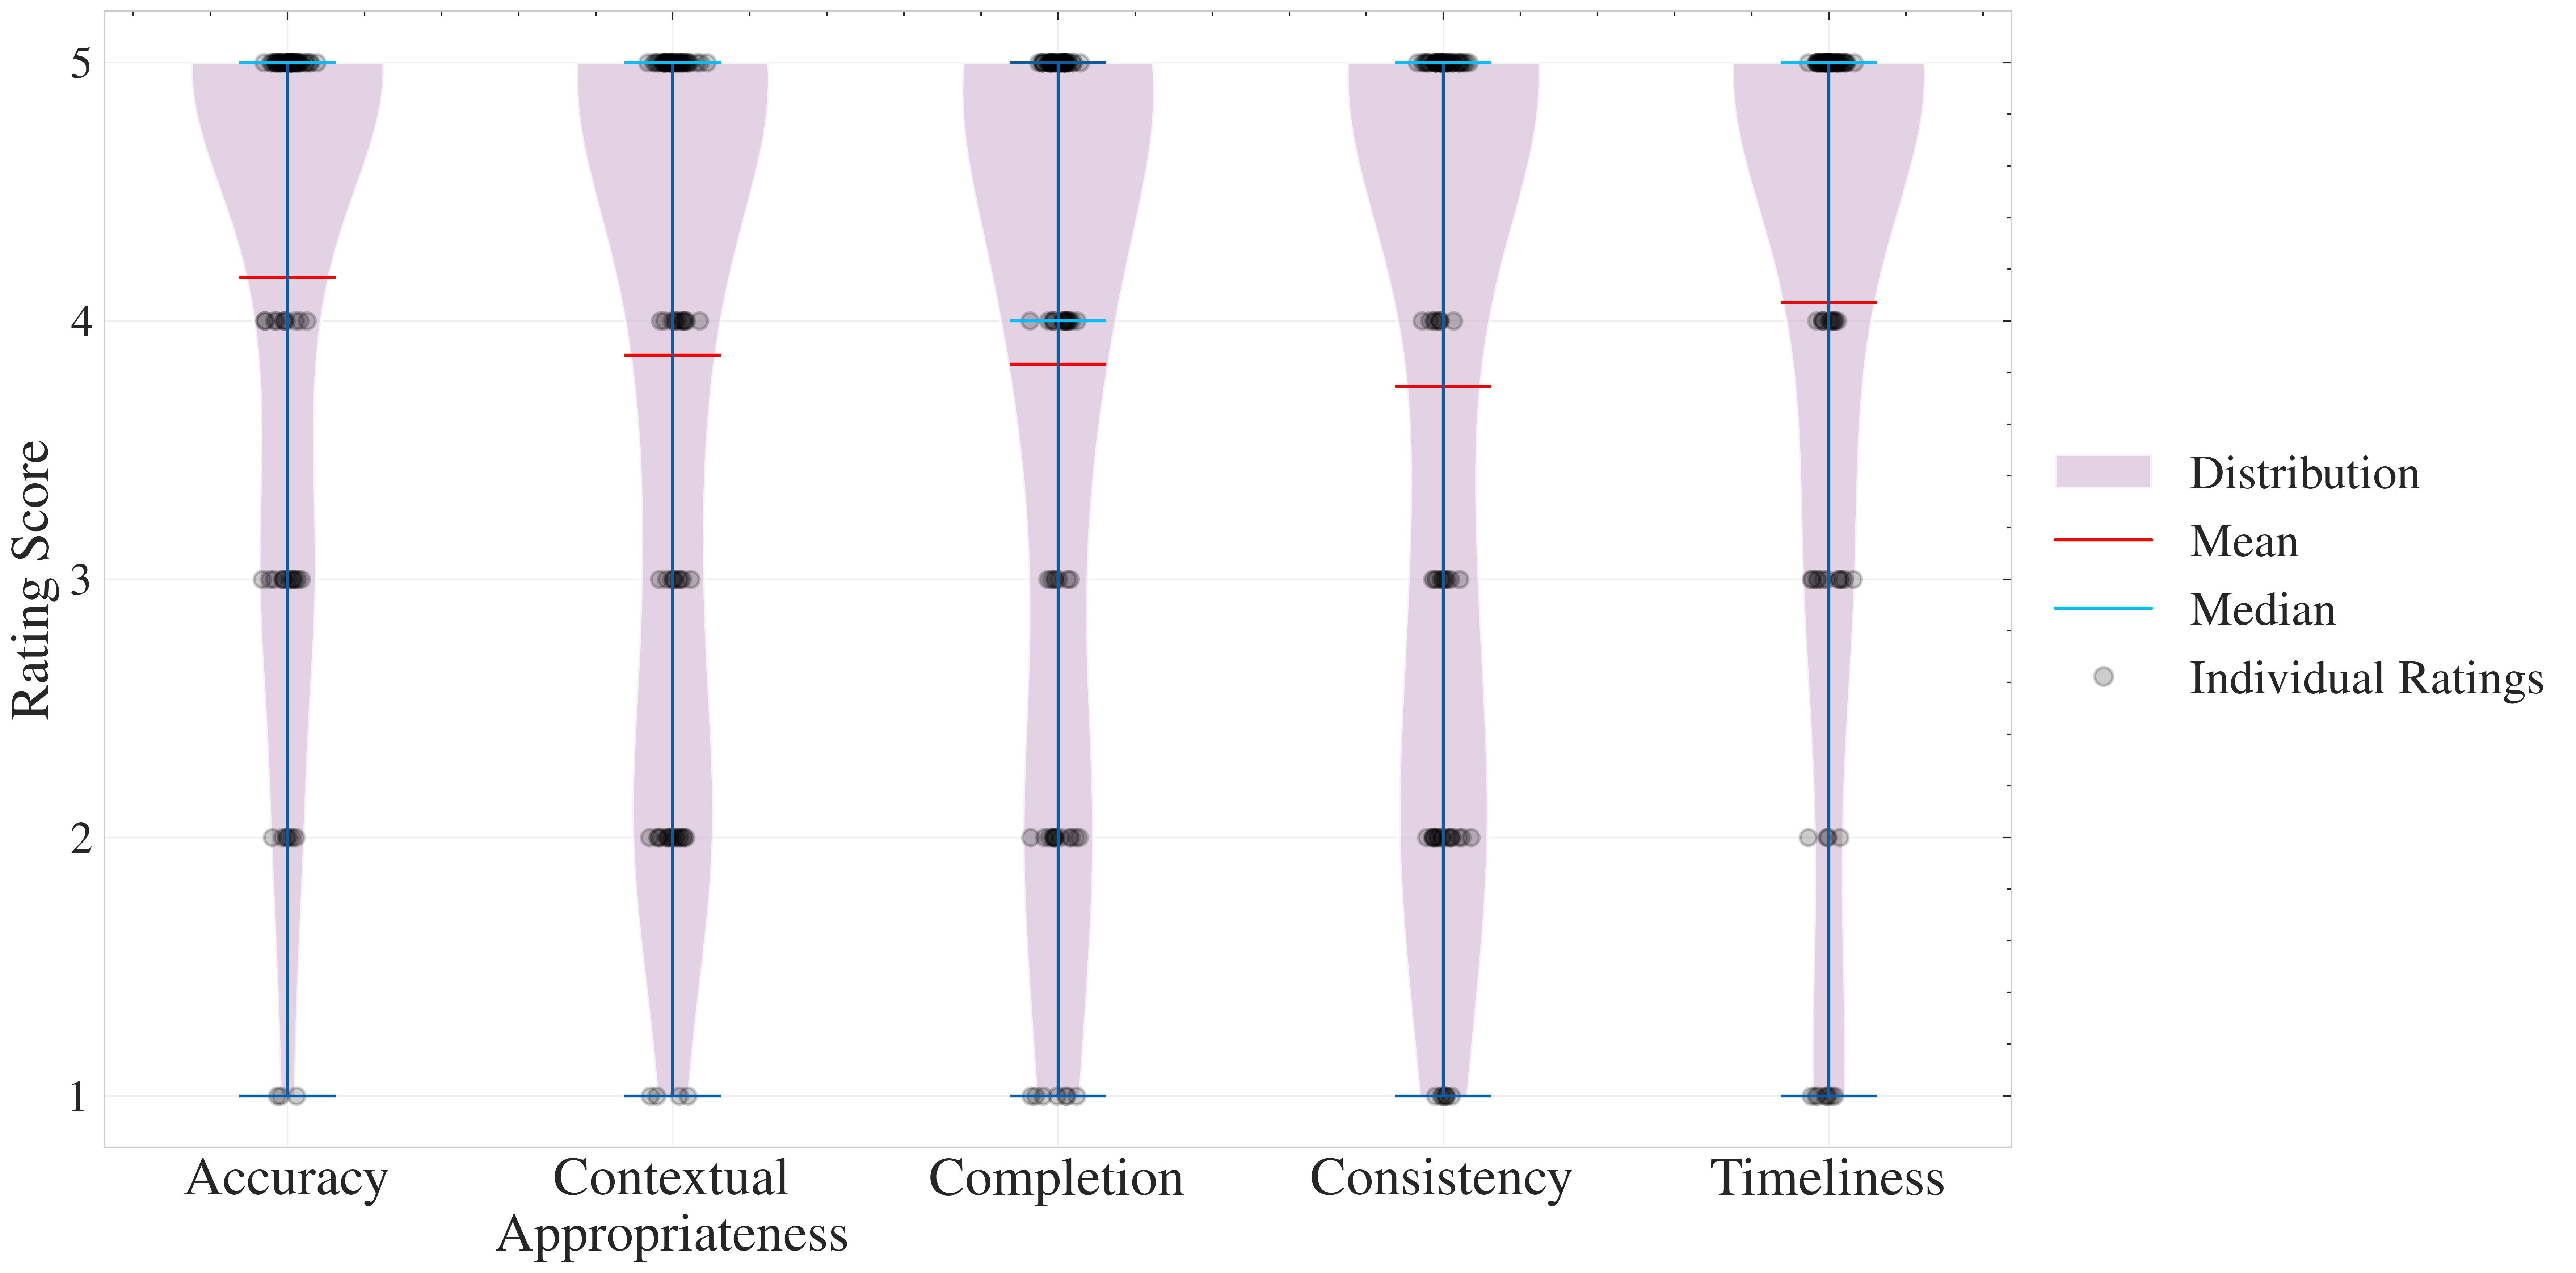

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(['science'])

dimensions = ['Accurate', 'Contextualized', 'Completed', 'Consistent', 'Timeliness']
data = evs.select(dimensions).to_dict(as_series=False)

plt.figure(figsize=(12, 6))
violin_parts = plt.violinplot([data[dim] for dim in dimensions],
                             showmeans=True,
                             showmedians=True)

violin_parts['cmeans'].set_color('red')
violin_parts['cmedians'].set_color('deepskyblue')
for pc in violin_parts['bodies']:
    pc.set_facecolor('#D8BFD8')
    pc.set_alpha(0.7)

for i, dim in enumerate(dimensions, 1):
    y = data[dim]
    # Add jitter to x positions
    x = np.random.normal(i, 0.03, size=len(y))
    plt.scatter(x, y, alpha=0.2, color='black', s=30)

xlabels = ['Accuracy', 'Contextual\n Appropriateness', 'Completion', 'Consistency', 'Timeliness']
plt.xticks(range(1, len(dimensions) + 1), xlabels, fontsize=18)
plt.ylim(0.8, 5.2)
plt.yticks(range(1, 6), fontsize=15)
plt.grid(True, alpha=0.3)
#plt.title('Distribution of Ratings Across Dimensions', pad=20)
plt.ylabel('Rating Score', fontsize=18)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#D8BFD8', alpha=0.7, label='Distribution'),
    plt.Line2D([0], [0], color='red', label='Mean'),
    plt.Line2D([0], [0], color='deepskyblue', label='Median'),
    plt.Line2D([0], [0], marker='o', color='black', alpha=0.2, 
               label='Individual Ratings', linestyle='None')
]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.tight_layout()
plt.savefig('/home/leo/Desktop/dhdk/Master thesis/Tesi/figures/qualitative_violinplot.png')
plt.show()

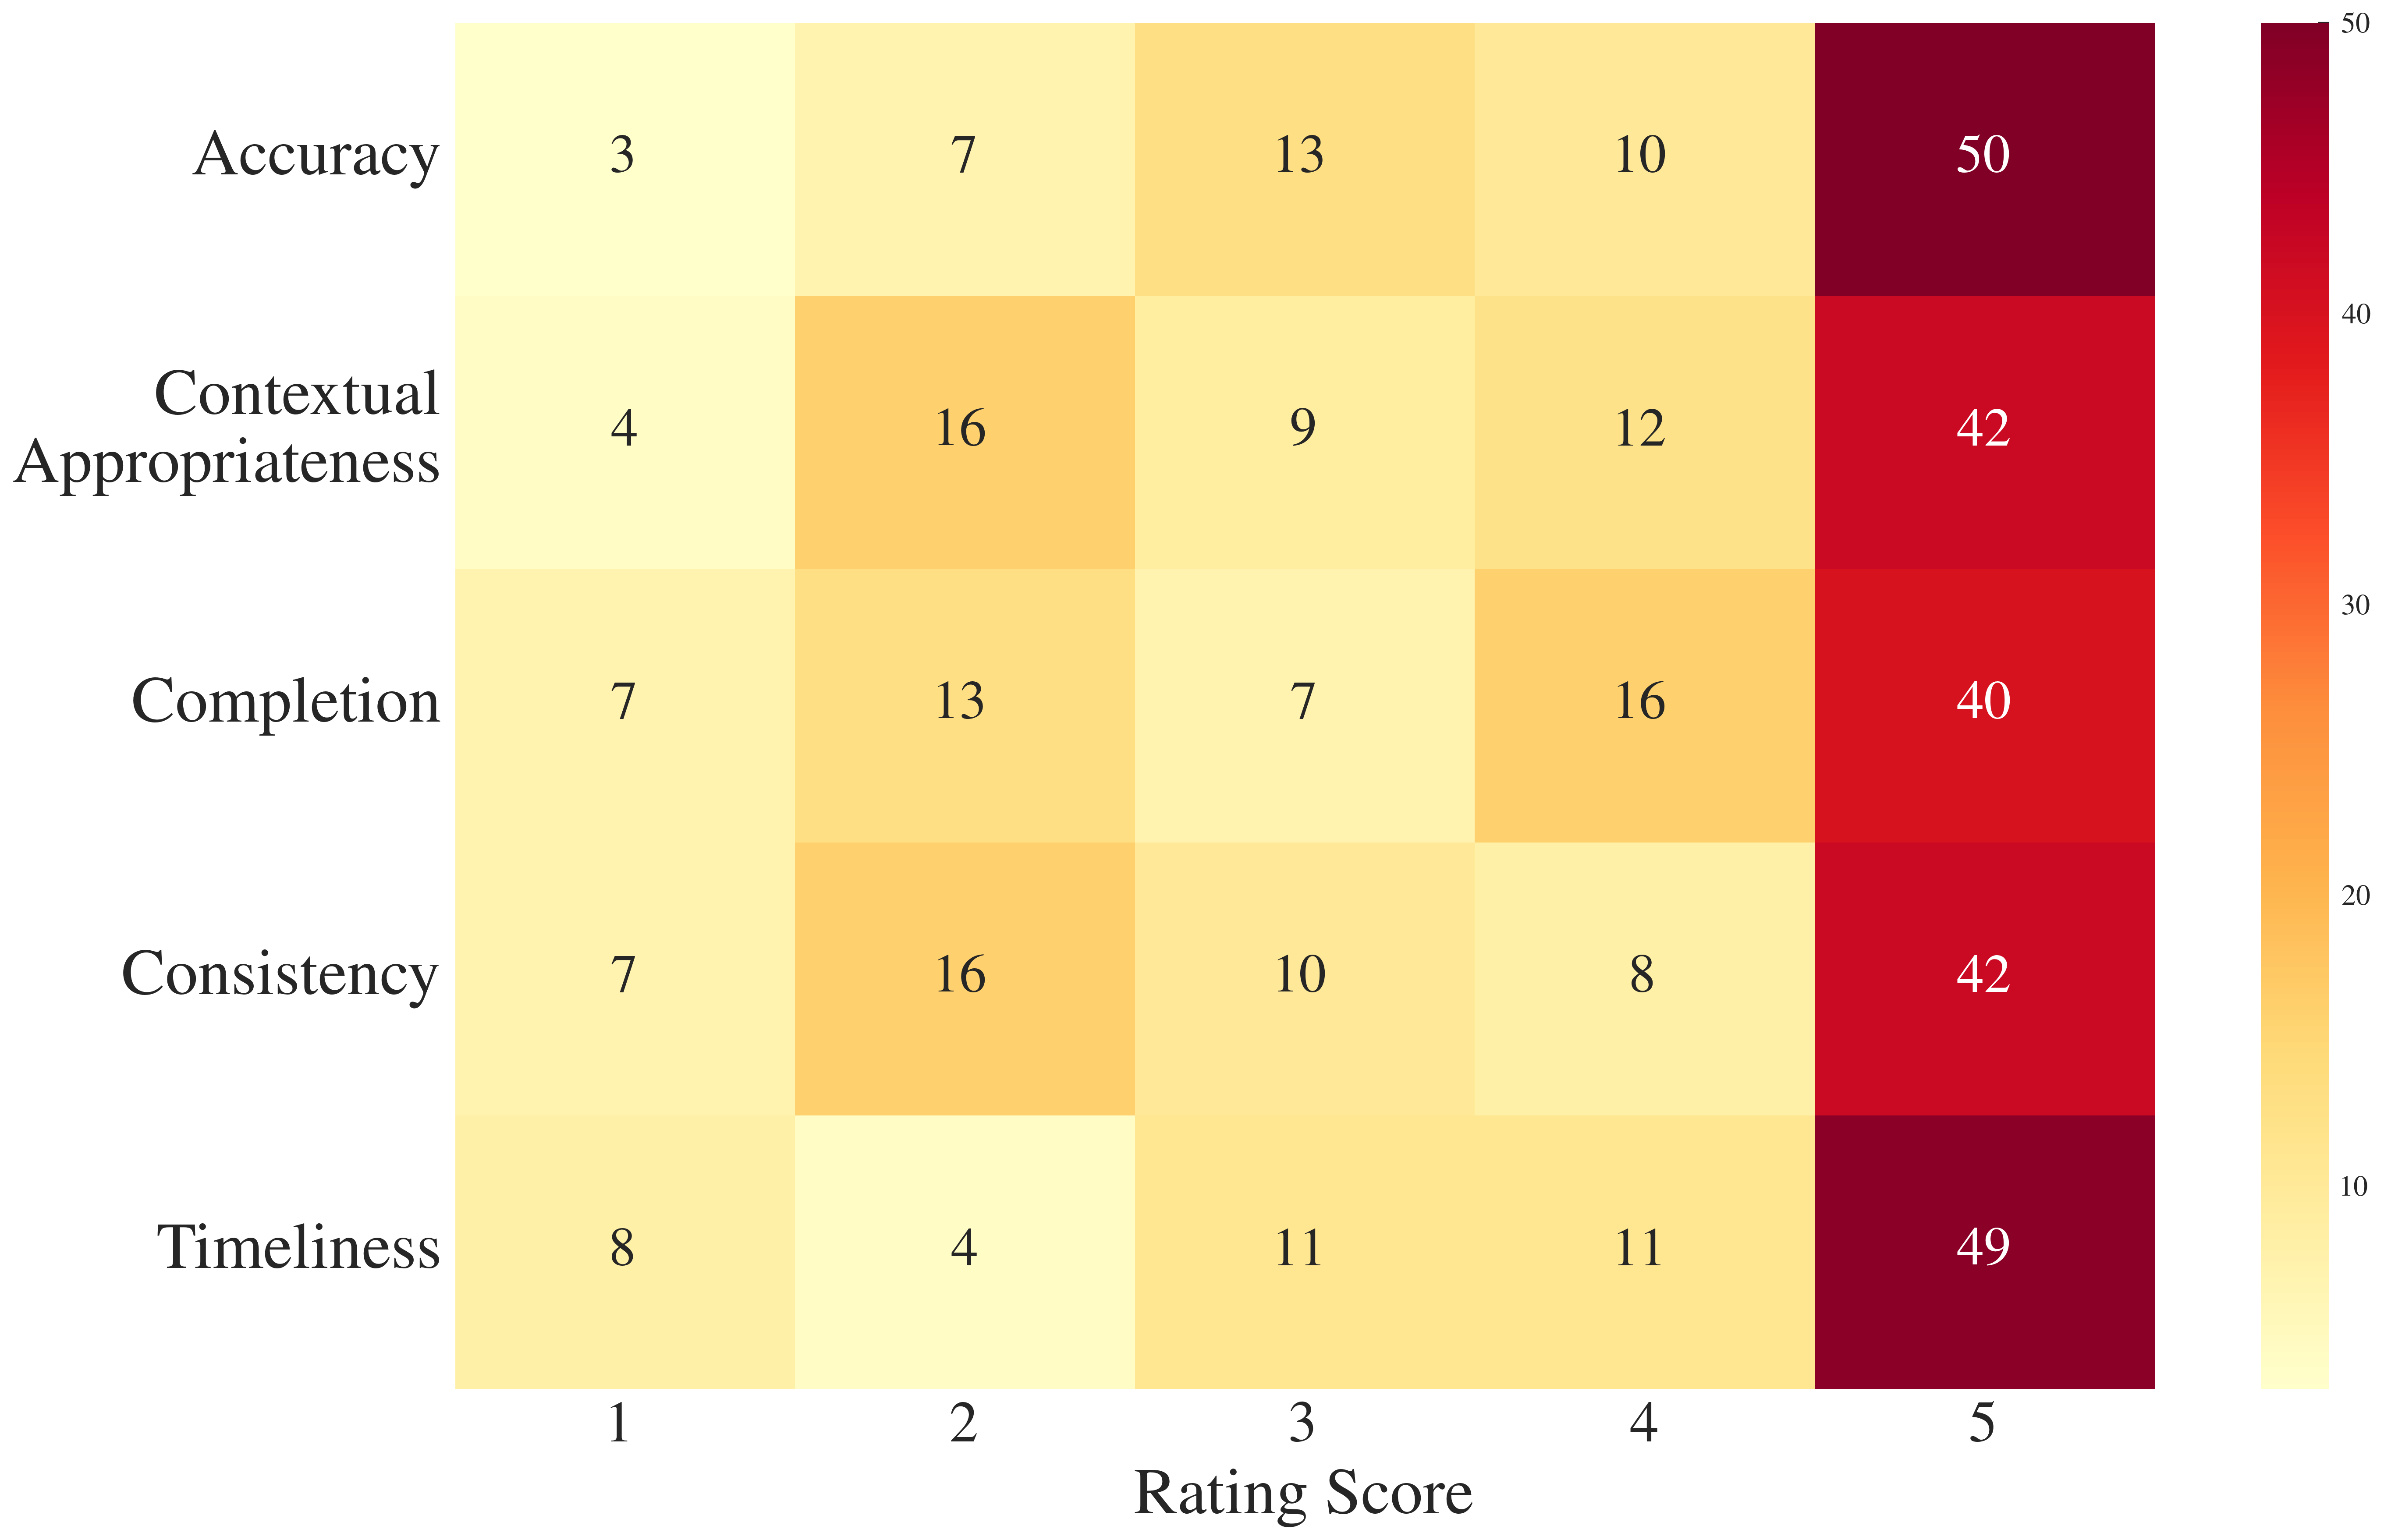

In [ ]:
plt.figure(figsize=(10, 6))
count_data = []
for dim in dimensions:
    counts = [sum(1 for x in data[dim] if x == i) for i in range(1, 6)]
    count_data.append(counts)

sns.heatmap(count_data, 
            annot=True, 
            fmt='d',
            cmap='YlOrRd',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=xlabels,
            annot_kws={"fontsize": 15})
plt.xlabel('Rating Score', fontsize=18)
plt.yticks(rotation=0, fontsize=18) 
plt.xticks(rotation=0, fontsize=16) 
plt.tight_layout()
plt.savefig('/home/leo/Desktop/dhdk/Master thesis/Tesi/figures/qualitative_heatmap.png')
plt.show()